# Transfer learning
- [Resource](https://lightning.ai/courses/deep-learning-fundamentals/unit-7-overview-getting-started-with-computer-vision/unit-7.6-leveraging-pretrained-models-with-transfer-learning/)
- [HF vit simple](https://colab.research.google.com/github/nateraw/huggingface-hub-examples/blob/main/vit_image_classification_explained.ipynb#scrollTo=m3BarCEpe4Z4)
- [HF vit web page](https://huggingface.co/blog/fine-tune-vit)
- [HF + lightning](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_PyTorch_Lightning.ipynb)

Let's start by installing the relevant libraries.

In [ ]:
!pip install -q transformers datasets lightning evaluate grad-cam torchinfo

## Load the data

Here we import a small portion of CIFAR-10, for demonstration purposes. This dataset can be found on the [hub](https://huggingface.co/datasets/cifar10) (you can view images directly in your browser!).

In [ ]:
from datasets import load_dataset


In [ ]:
from pathlib import Path
import shutil as sh
from typing import Optional
from PIL import Image
import requests

## Imports

In [ ]:
import os
from typing import Optional


import torch
import numpy as np
import torch.nn as nn
import albumentations as A
import lightning as L
import torchvision as tv
import torchvision.datasets as tv_ds
import torchvision.models as tv_models

from datasets import load_dataset
from torchvision.transforms import v2
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, random_split

from typing import Optional

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryAUROC,
    BinaryAveragePrecision,
    BinaryF1Score,
    BinaryStatScores,
)

## Download data

In [ ]:
!curl -L -o ./archive.zip https://www.kaggle.com/api/v1/datasets/download/fanconic/skin-cancer-malignant-vs-benign

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  324M  100  324M    0     0  20.4M      0  0:00:15  0:00:15 --:--:-- 23.4M


In [ ]:
!rm -rf dataset
!rm -rf final_dataset
!unzip -q archive.zip -d dataset

In [ ]:
DATASET_PATH = Path("/content/final_dataset")

TRAIN_DS_PATH = DATASET_PATH / "train"
TEST_DS_PATH = DATASET_PATH / "test"
VALID_DS_PATH = DATASET_PATH / "valid"

TRAIN_DS_PATH.mkdir(parents=True, exist_ok=True)
TEST_DS_PATH.mkdir(parents=True, exist_ok=True)
VALID_DS_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
def copy_files(
        src_dir: Path,
        dest_dir: Path,
        file_pattern: str,
        num_files: Optional[int] = None,
        verbose: bool = False,
    ):
    dest_dir.mkdir(parents=True, exist_ok=True)
    files = src_dir.glob(file_pattern)
    counts = 0
    for file_ in sorted(files):
        if num_files and counts >= num_files:
            break
        if verbose:
            print(f"Copying {file_} to {dest_dir}...")
        counts += 1
        sh.move(file_, dest_dir)
        # sh.copy(file_, dest_dir)


In [ ]:

test_dir = Path("/content/dataset/test")
copy_files(test_dir / "benign", TEST_DS_PATH / "benign", file_pattern="*.jpg")
copy_files(test_dir / "malignant", TEST_DS_PATH / "malignant", file_pattern="*.jpg")
print(f"test malignant - {len(list((TEST_DS_PATH / 'malignant').glob('*.jpg')))}")
print(f"test benign - {len(list((TEST_DS_PATH / 'benign').glob('*.jpg')))}")

train_dir = Path("/content/dataset/train")
copy_files(train_dir / "benign", VALID_DS_PATH / "benign", file_pattern="*.jpg", num_files=300)
copy_files(train_dir / "malignant", VALID_DS_PATH / "malignant", file_pattern="*.jpg", num_files=300)
print(f"valid malignant - {len(list((VALID_DS_PATH / 'malignant').glob('*.jpg')))}")
print(f"valid benign - {len(list((VALID_DS_PATH / 'benign').glob('*.jpg')))}")

copy_files(train_dir / "benign", TRAIN_DS_PATH / "benign", file_pattern="*.jpg")
copy_files(train_dir / "malignant", TRAIN_DS_PATH / "malignant", file_pattern="*.jpg")
print(f"train malignant - {len(list((TRAIN_DS_PATH / 'malignant').glob('*.jpg')))}")
print(f"train benign - {len(list((TRAIN_DS_PATH / 'benign').glob('*.jpg')))}")

!rm -rf ./dataset


test malignant - 300
test benign - 360
valid malignant - 300
valid benign - 300
train malignant - 897
train benign - 1140


In [ ]:
skin_dataset = load_dataset("imagefolder", data_dir="/content/final_dataset")
skin_dataset


Resolving data files:   0%|          | 0/2037 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/600 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/660 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2037
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 660
    })
})

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7B872797B3A0>, 'label': 0}


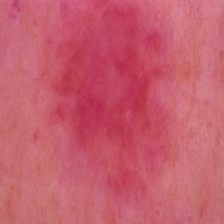

In [ ]:
ex = skin_dataset['train'][0]
print(ex)
image = ex["image"]
image

In [ ]:
train_ds = skin_dataset["train"]
valid_ds = skin_dataset["validation"]
test_ds = skin_dataset["test"]

We can also check out the features of the dataset in more detail:

In [ ]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['benign', 'malignant'], id=None)}

As we can see, each example has 2 features: 'img' (of type `Image`) and 'label' (of type `ClassLabel`). Let's check an example of the training dataset:

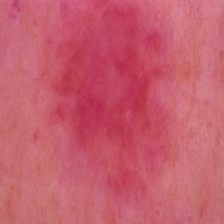

In [ ]:
train_ds[0]['image']

In [ ]:
train_ds[0]['label']

0

Of course, we would like to know the actual class name, rather than the integer index. We can obtain that by creating a dictionary which maps between integer indices and actual class names (id2label):

In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label, label2id

({0: 'benign', 1: 'malignant'}, {'benign': 0, 'malignant': 1})

In [ ]:
id2label[train_ds[0]['label']]

'benign'

## Preprocessing the data

We will now preprocess the data. The model requires 2 things: `pixel_values` and `labels`.

We will perform data augmentaton **on-the-fly** using HuggingFace Datasets' `set_transform` method (docs can be found [here](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)). This method is kind of a lazy `map`: the transform is only applied when examples are accessed. This is convenient for tokenizing or padding text, or augmenting images at training time for example, as we will do here.

We first load the image processor, which is a minimal object that can be used to prepare images for inference. We use some of its properties which are relevant for preparing images for the model.

In [ ]:

from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

In [ ]:
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

For data augmentation, one can use any available library. Here we'll use torchvision's [transforms module](https://pytorch.org/vision/stable/transforms.html).

In [ ]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [ ]:
# Set the transforms
train_ds.set_transform(train_transforms)
valid_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

We can now load preprocessed images (on-the-fly) as follows:

In [ ]:
train_ds[:2]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>],
 'label': [0, 0],
 'pixel_values': [tensor([[[ 0.4824,  0.4824,  0.4902,  ...,  0.5529,  0.5608,  0.5686],
           [ 0.4902,  0.4824,  0.4902,  ...,  0.5608,  0.5608,  0.5686],
           [ 0.4980,  0.4902,  0.4824,  ...,  0.5765,  0.5686,  0.5686],
           ...,
           [ 0.5765,  0.5686,  0.5608,  ...,  0.5373,  0.5294,  0.5294],
           [ 0.5686,  0.5608,  0.5686,  ...,  0.5294,  0.5216,  0.5137],
           [ 0.5608,  0.5608,  0.5686,  ...,  0.5216,  0.5137,  0.5059]],
  
          [[-0.5451, -0.5451, -0.5373,  ..., -0.1922, -0.1843, -0.1843],
           [-0.5529, -0.5529, -0.5451,  ..., -0.1843, -0.1765, -0.1765],
           [-0.5686, -0.5608, -0.5529,  ..., -0.1765, -0.1686, -0.1686],
           ...,
           [-0.1843, -0.1843, -0.1922,  ..., -0.1451, -0.1529, -0.1608],
           [-0.2000, -0.1922, -0.1843,  ..., -0.1451, -0

In [ ]:
valid_ds[:2]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>],
 'label': [0, 0],
 'pixel_values': [tensor([[[0.7412, 0.7490, 0.7490,  ..., 0.6627, 0.6392, 0.6314],
           [0.7333, 0.7255, 0.7176,  ..., 0.6314, 0.6549, 0.6784],
           [0.7490, 0.7647, 0.7333,  ..., 0.6627, 0.6627, 0.6627],
           ...,
           [0.5373, 0.5765, 0.5608,  ..., 0.5294, 0.5529, 0.5686],
           [0.5529, 0.5686, 0.5529,  ..., 0.5451, 0.5608, 0.5765],
           [0.5529, 0.5608, 0.5451,  ..., 0.4980, 0.5294, 0.5529]],
  
          [[0.3725, 0.3882, 0.3882,  ..., 0.2235, 0.2000, 0.2000],
           [0.3412, 0.3725, 0.3490,  ..., 0.2000, 0.2157, 0.2157],
           [0.3647, 0.3882, 0.3647,  ..., 0.2235, 0.2392, 0.2235],
           ...,
           [0.1922, 0.2157, 0.1922,  ..., 0.1294, 0.1529, 0.1529],
           [0.1686, 0.1843, 0.1843,  ..., 0.1137, 0.1686, 0.1608],
           [0.1686, 0.1608, 0.1765,  ..., 0.1137,

It's very easy to create corresponding PyTorch DataLoaders, like so:

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 2
eval_batch_size = 2

train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size)
val_dataloader = DataLoader(valid_ds, collate_fn=collate_fn, batch_size=eval_batch_size)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=eval_batch_size)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([2, 3, 224, 224])
labels torch.Size([2])


In [ ]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)

In [ ]:
next(iter(val_dataloader))['pixel_values'].shape

torch.Size([2, 3, 224, 224])

## Define the model

Here we define a `LightningModule`, which is very similar to a regular `nn.Module`, but with some additional functionalities.

The model itself uses a linear layer on top of a pre-trained `ViTModel`. We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. We also add dropout for regularization.

A resource that helped me in understanding PyTorch Lightning is the [documentation](https://pytorch-lightning.readthedocs.io/en/latest/index.html) as well as the [tutorial notebooks](https://github.com/PyTorchLightning/pytorch-lightning/tree/master/notebooks).

In [ ]:
from transformers import ViTForImageClassification
import torch.nn as nn

class ViTLightningModule(L.LightningModule):
    def __init__(self, num_labels=10):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=2,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits

    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy

    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss, prog_bar=True,)
        self.log("training_accuracy", accuracy, prog_bar=True,)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True, prog_bar=True,)
        self.log("validation_accuracy", accuracy, on_epoch=True, prog_bar=True,)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("test_loss", loss, prog_bar=True,)
        self.log("test_accuracy", accuracy, prog_bar=True,)
        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return torch.optim.AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

## Train the model

Let's first start up Tensorboard (note that PyTorch Lightning logs to Tensorboard by default):

In [ ]:
# Start tensorboard.
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

Let's initialize the model, and train it!

We also add a callback:
* early stopping (stop training once the validation loss stops improving after 3 times).

In [ ]:
monitor_metric = 'validation_loss'
monitor_mode = 'min'

checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    save_top_k=3,
    save_last=True,
    monitor=monitor_metric,
    mode=monitor_mode,
    filename="{epoch:02d}-{valid_acc:.4f}",
    dirpath="./model_ckpt_clbk",
)
lr_callback = L.pytorch.callbacks.LearningRateMonitor()
early_stopping = L.pytorch.callbacks.EarlyStopping(
    monitor=monitor_metric,
    mode=monitor_mode,
    patience=5,
    verbose=True,
)

In [ ]:

model = ViTLightningModule()

trainer = L.Trainer(
    accelerator="auto",

    max_epochs=30,

    callbacks=[
        checkpoint_callback,
        lr_callback,
        early_stopping,
        L.pytorch.callbacks.StochasticWeightAveraging(swa_lrs=1e-2),
    ],
    enable_progress_bar=True,
    accumulate_grad_batches=4,
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type                      | Params | Mode
----------------------------------------------------------
0 | vit  | ViTForImageClassification | 85.8 M | eval
----------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.201   Total estimated model params size (MB)
0         Modules in train mode
226       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name | Type                      | Params | Mode
----------------------------------------------------------
0 | vit  | ViTForImageClassification | 85.8 M | eval
----------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.201   Total estimated model params size (MB)
0         Modules in train mode
226       M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric validation_loss improved. New best score: 0.536
INFO:lightning.pytorch.callbacks.early_stopping:Metric validation_loss improved. New best score: 0.536


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric validation_loss improved by 0.222 >= min_delta = 0.0. New best score: 0.314
INFO:lightning.pytorch.callbacks.early_stopping:Metric validation_loss improved by 0.222 >= min_delta = 0.0. New best score: 0.314


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric validation_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.292
INFO:lightning.pytorch.callbacks.early_stopping:Metric validation_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.292


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric validation_loss did not improve in the last 5 records. Best score: 0.292. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric validation_loss did not improve in the last 5 records. Best score: 0.292. Signaling Trainer to stop.


In [ ]:
trainer.test()

INFO: Restoring states from the checkpoint path at /content/model_ckpt_clbk/epoch=05-valid_acc=0.0000.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_ckpt_clbk/epoch=05-valid_acc=0.0000.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_ckpt_clbk/epoch=05-valid_acc=0.0000.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_ckpt_clbk/epoch=05-valid_acc=0.0000.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8954545259475708     │
│         test_loss         │    0.25293150544166565    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.25293150544166565, 'test_accuracy': 0.8954545259475708}]

In [ ]:
trained_model_path = checkpoint_callback.best_model_path
print(f"{trained_model_path = }")

trained_model_path = '/content/model_ckpt_clbk/epoch=05-valid_acc=0.0000.ckpt'


In [ ]:
loaded_model = ViTLightningModule.load_from_checkpoint(trained_model_path)
loaded_model.eval()
loaded_model.freeze()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# new_trainer = L.Trainer
test_results = trainer.test(loaded_model, test_dataloader)
print(test_results)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8954545259475708     │
│         test_loss         │    0.25293150544166565    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.25293150544166565, 'test_accuracy': 0.8954545259475708}]


Finally, let's test the trained model on the test set:

In [ ]:
loaded_model

ViTLightningModule(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
   

# prediction

# Grad CAM

In [ ]:
image = Image.open("/content/final_dataset/test/malignant/1003.jpg")
example_dict = {"image": image}
# inputs = processor(images=example_dict, return_tensors="pt")

def pred_transforms(example_d):
    print(example_d["image"])
    example_d['pixel_values'] = _val_transforms(example_d['image'].convert("RGB"))
    return example_d

inputs = pred_transforms(example_dict)
inputs

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7B8716483A30>


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'pixel_values': tensor([[[ 0.7020,  0.7255,  0.7490,  ...,  0.3725,  0.3882,  0.4039],
          [ 0.7176,  0.7412,  0.7725,  ...,  0.3647,  0.3490,  0.3647],
          [ 0.7333,  0.7647,  0.7412,  ...,  0.3176,  0.2941,  0.3255],
          ...,
          [ 0.6706,  0.6706,  0.6627,  ...,  0.5529,  0.5529,  0.5608],
          [ 0.6863,  0.6706,  0.6392,  ...,  0.5373,  0.5529,  0.5529],
          [ 0.6784,  0.6392,  0.6627,  ...,  0.5373,  0.5373,  0.5451]],
 
         [[ 0.4353,  0.4353,  0.4588,  ..., -0.0431, -0.0510, -0.0353],
          [ 0.4510,  0.4667,  0.4980,  ..., -0.0902, -0.0980, -0.0824],
          [ 0.4667,  0.4902,  0.4980,  ..., -0.1451, -0.1608, -0.1451],
          ...,
          [ 0.3725,  0.3647,  0.3569,  ...,  0.3176,  0.3176,  0.3098],
          [ 0.3725,  0.3647,  0.3647,  ...,  0.3020,  0.3176,  0.3176],
          [ 0.3647,  0.3569,  0.3647,  ...,  0.3020,  0.3020,  0.2941]],
 
         

In [ ]:
loaded_model(inputs["pixel_values"].unsqueeze(0)).softmax(dim=1)

tensor([[0.0177, 0.9823]])

In [ ]:
processor(image)

{'pixel_values': [array([[[ 0.7019608 ,  0.7254902 ,  0.7490196 , ...,  0.37254906,
          0.38823533,  0.4039216 ],
        [ 0.7176471 ,  0.7411765 ,  0.77254903, ...,  0.36470592,
          0.34901965,  0.36470592],
        [ 0.73333335,  0.7647059 ,  0.7411765 , ...,  0.3176471 ,
          0.2941177 ,  0.32549024],
        ...,
        [ 0.67058825,  0.67058825,  0.6627451 , ...,  0.5529412 ,
          0.5529412 ,  0.56078434],
        [ 0.6862745 ,  0.67058825,  0.6392157 , ...,  0.5372549 ,
          0.5529412 ,  0.5529412 ],
        [ 0.6784314 ,  0.6392157 ,  0.6627451 , ...,  0.5372549 ,
          0.5372549 ,  0.54509807]],

       [[ 0.43529415,  0.43529415,  0.45882356, ..., -0.04313725,
         -0.05098039, -0.03529412],
        [ 0.45098042,  0.4666667 ,  0.49803925, ..., -0.09019607,
         -0.09803921, -0.08235294],
        [ 0.4666667 ,  0.4901961 ,  0.49803925, ..., -0.14509803,
         -0.1607843 , -0.14509803],
        ...,
        [ 0.37254906,  0.36470592,  

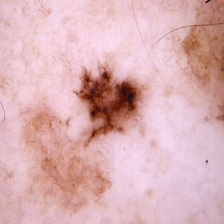

In [ ]:
image

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional

""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]

""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.

"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module,
                          input_image: Image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)


def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/content/final_dataset/test/malignant/1.jpg
ImageClassifierOutput(loss=None, logits=tensor([[-0.4961,  0.4568]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor([[0.2783, 0.7217]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([2, 196, 768])
torch.Size([2, 196, 768])


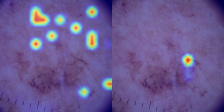

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    print(activations.shape)

    activations = activations.view(activations.shape[0], 14, 14, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations


loaded_model2 = ViTLightningModule.load_from_checkpoint(trained_model_path)
loaded_model2.eval()
model = loaded_model2.vit

targets_for_gradcam = [
    ClassifierOutputTarget(category_name_to_index(model, "benign")),
    ClassifierOutputTarget(category_name_to_index(model, "malignant")),

]

target_layer_gradcam = model.vit.encoder.layer[-2].output

malignant_labels = ["1", "1003", "1005", "1007", "1009", "1012", ]
idx = 0
img_path = f"/content/final_dataset/test/malignant/{malignant_labels[idx]}.jpg"
print(img_path)

image = Image.open(img_path)
image_resized = image.resize((224, 224))
tensor_resized = transforms.ToTensor()(image_resized).to("cuda")

outs = model(torch.unsqueeze(tensor_resized, dim=0))
print(outs)
probs = outs.logits.softmax(dim=1)
print(probs)

out_img = Image.fromarray(
    run_grad_cam_on_image(
        model=model,
        target_layer=target_layer_gradcam,
        targets_for_gradcam=targets_for_gradcam,
        input_tensor=tensor_resized,
        input_image=image_resized,
        reshape_transform=reshape_transform_vit_huggingface
    )
)

display(out_img)


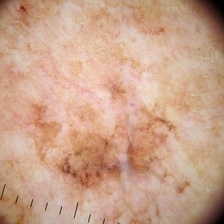

In [ ]:
image_resized

In [ ]:
!zip -r final_dataset.zip final_dataset

updating: final_dataset/ (stored 0%)
updating: final_dataset/valid/ (stored 0%)
updating: final_dataset/valid/benign/ (stored 0%)
updating: final_dataset/valid/benign/1250.jpg (deflated 0%)
updating: final_dataset/valid/benign/1241.jpg (deflated 0%)
updating: final_dataset/valid/benign/1106.jpg (deflated 0%)
updating: final_dataset/valid/benign/1274.jpg (deflated 0%)
updating: final_dataset/valid/benign/1252.jpg (deflated 0%)
updating: final_dataset/valid/benign/1138.jpg (deflated 0%)
updating: final_dataset/valid/benign/1045.jpg (deflated 0%)
updating: final_dataset/valid/benign/1102.jpg (deflated 0%)
updating: final_dataset/valid/benign/1336.jpg (deflated 0%)
updating: final_dataset/valid/benign/1046.jpg (deflated 0%)
updating: final_dataset/valid/benign/1236.jpg (deflated 0%)
updating: final_dataset/valid/benign/1158.jpg (deflated 0%)
updating: final_dataset/valid/benign/132.jpg (deflated 0%)
updating: final_dataset/valid/benign/1312.jpg (deflated 0%)
updating: final_dataset/valid/b